In [1]:
import functools
from WeightDecay import WeightDecay
import matplotlib.pyplot as plt
import imlib as im
import numpy as np
import pylib as py
import tensorflow as tf
import tensorflow.keras as keras
import tf2lib as tl
import tf2gan as gan
import tqdm
import glob
import data
import module
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

In [2]:
BUFFER_SIZE = 1000
load_size = 72
crop_size = 64
batch_size = 1
epochs = 50
len_dataset = 30000
epoch_decay = epochs // 2
lr = 0.0002
beta_1 = 0.5
adversarial_loss_mode = 'gan'
gradient_penalty_mode = 'none'
gradient_penalty_weight = 10
cycle_loss_weight = 10
identity_loss_weight = 5
pool_size = 50
output_dir = "/home/palaniswamyji/Baseline/ws2020_janaranjanikoushik/"
G_losses = []
D_losses = []

In [3]:
def train_parse_func(filename):
    # Read the image
    image_string = tf.io.read_file(filename)

    # Decode the image
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # Normalize the image
    image = tf.cast(image_decoded, tf.float32)
    image = ((image / 127.5) - 1)

    # resizing to 72 x 72 x 3
    image = tf.image.resize(image, [load_size, load_size],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # random crop to 64 x 64 x 3
    image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
    # random mirroring
    image = tf.image.random_flip_left_right(image)
    
    return image

In [4]:
def test_parse_func(filename):
    # Read the image
    image_string = tf.io.read_file(filename)

    # Decode the image
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)

    # Normalize the image
    image = tf.cast(image_decoded, tf.float32)
    image = ((image / 127.5) - 1)

    # resizing to 64 x 64 x 3
    image = tf.image.resize(image, [crop_size, crop_size],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

In [5]:
# loading dataset from file
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset_real = glob.glob("/home/palaniswamyji/celebA_ds/*")
dataset_comic = glob.glob("/home/palaniswamyji/facemaker_ds/*")

# Count of dataset
dataset_real_count = 30000
dataset_comic_count = 30000

# Training count
dataset_real_training_count = int(dataset_real_count * 0.8)
dataset_comic_training_count = int(dataset_comic_count * 0.8)

# Split training and test dataset
train_real = tf.data.Dataset.from_tensor_slices(dataset_real[0:dataset_real_training_count])
test_real = tf.data.Dataset.from_tensor_slices(dataset_real[dataset_real_training_count:dataset_real_count])
train_comic = tf.data.Dataset.from_tensor_slices(dataset_comic[0:dataset_comic_training_count])
test_comic = tf.data.Dataset.from_tensor_slices(dataset_comic[dataset_comic_training_count:dataset_comic_count])

A2B_pool = data.ItemPool(pool_size)
B2A_pool = data.ItemPool(pool_size)

train_comic = train_comic.map(
    train_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(batch_size)

test_comic = test_comic.map(
    test_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(batch_size)

train_real = train_real.map(
    train_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(batch_size)

test_real = test_real.map(
    test_parse_func, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(batch_size)

A_B_dataset = tf.data.Dataset.zip((train_comic, train_real))
A_B_dataset_test = tf.data.Dataset.zip((test_comic, test_real))

len_dataset = dataset_real_training_count

In [6]:
G_A2B = module.ResnetGenerator(input_shape=(crop_size, crop_size, 3))
G_B2A = module.ResnetGenerator(input_shape=(crop_size, crop_size, 3))

D_B = module.ConvDiscriminator(input_shape=(crop_size, crop_size, 3))

inceptionModel = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(75, 75, 3), pooling=None, classes=1000, classifier_activation='softmax')

d_loss_fn, g_loss_fn = gan.get_adversarial_losses_fn(adversarial_loss_mode)
cycle_loss_fn = tf.losses.MeanAbsoluteError()
identity_loss_fn = tf.losses.MeanAbsoluteError()

G_lr_scheduler = module.LinearDecay(lr, epochs * len_dataset, epoch_decay * len_dataset)
D_lr_scheduler = module.LinearDecay(lr, epochs * len_dataset, epoch_decay * len_dataset)
G_optimizer = keras.optimizers.Adam(learning_rate=G_lr_scheduler, beta_1=beta_1)
D_optimizer = keras.optimizers.Adam(learning_rate=D_lr_scheduler, beta_1=beta_1)

In [7]:
def imageToFeatureVector(image):
    image = tf.image.resize(image, [75, 75], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.reshape(image, (1, 75, 75, 3), name=None)
    return inceptionModel(image)

In [8]:
@tf.function
def train_G(A, B):
    with tf.GradientTape() as t:
        A2B = G_A2B(A, training=True)
        A2B2A = G_B2A(A2B, training=True)
        B2B = G_A2B(B, training=True)

        A2B_d_logits = D_B(A2B, training=True)

        A2B_g_loss = g_loss_fn(A2B_d_logits)
        
        A2B2A_cycle_loss = cycle_loss_fn(A, A2B2A)
        B2B_id_loss = identity_loss_fn(B, B2B)

        G_loss = (A2B_g_loss) + (A2B2A_cycle_loss) * cycle_loss_weight + (B2B_id_loss) * identity_loss_weight
        
    G_grad = t.gradient(G_loss, G_A2B.trainable_variables + G_B2A.trainable_variables)
    G_optimizer.apply_gradients(zip(G_grad, G_A2B.trainable_variables + G_B2A.trainable_variables))

    return A2B, G_loss, {'A2B_g_loss': A2B_g_loss,
                         'A2B2A_cycle_loss': A2B2A_cycle_loss,
                         'B2B_id_loss': B2B_id_loss}

In [9]:
@tf.function
def train_D(A, B, A2B):
    with tf.GradientTape() as t:
        B_d_logits = D_B(B, training=True)
        A2B_d_logits = D_B(A2B, training=True)

        B_d_loss, A2B_d_loss = d_loss_fn(B_d_logits, A2B_d_logits)
        D_B_gp = gan.gradient_penalty(functools.partial(D_B, training=True), B, A2B, mode=gradient_penalty_mode)

        D_loss = (B_d_loss + A2B_d_loss) + (D_B_gp) * gradient_penalty_weight

    D_grad = t.gradient(D_loss, D_B.trainable_variables)
    D_optimizer.apply_gradients(zip(D_grad, D_B.trainable_variables))

    return D_loss, {'B_d_loss': B_d_loss + A2B_d_loss,
                    'D_B_gp': D_B_gp}

In [10]:
def train_step(A, B):
    A2B, G_loss, G_loss_dict = train_G(A, B)

    # cannot autograph `A2B_pool`
    A2B = A2B_pool(A2B)  # or A2B = A2B_pool(A2B.numpy()), but it is much slower because of the communication between CPU and GPU

    D_loss, D_loss_dict = train_D(A, B, A2B)
    
    return G_loss_dict, D_loss_dict, G_loss, D_loss

In [11]:
@tf.function
def sample(A, B):
    A2B = G_A2B(A, training=False)
    A2B2A = G_B2A(A2B, training=False)
    return A2B, A2B2A

In [12]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])

        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    plt.show()

Inner Epoch Loop:   0%|          | 0/8 [00:00<?, ?it/s]

<tf.Variable 'Variable:0' shape=() dtype=int64, numpy=8>



Inner Epoch Loop: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it]


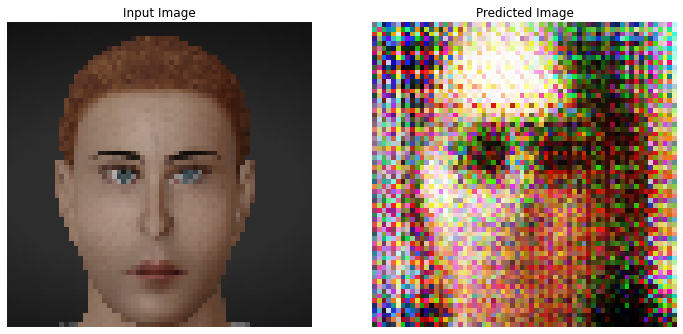

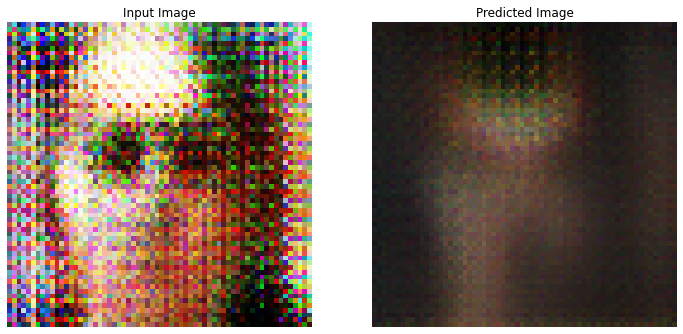

Inner Epoch Loop: 100%|██████████| 8/8 [00:00<00:00,  8.66it/s]


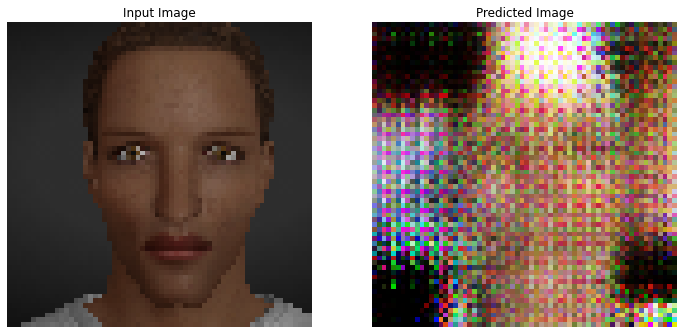

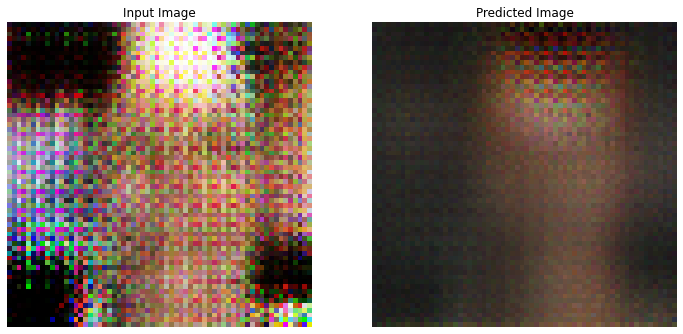

Inner Epoch Loop: 100%|██████████| 8/8 [00:00<00:00,  9.12it/s]


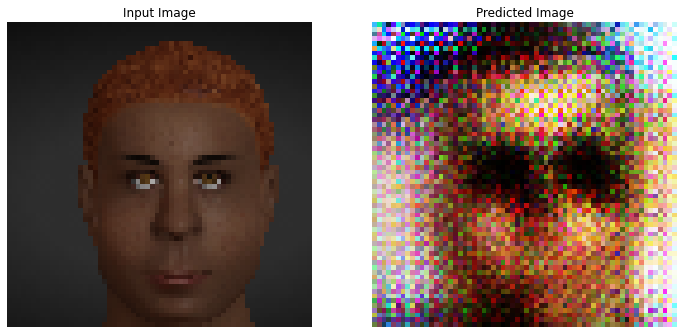

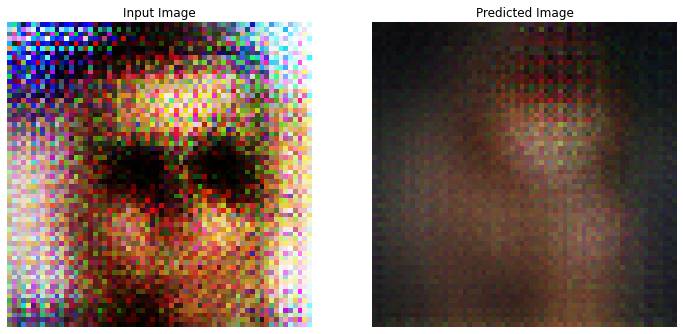

Inner Epoch Loop: 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


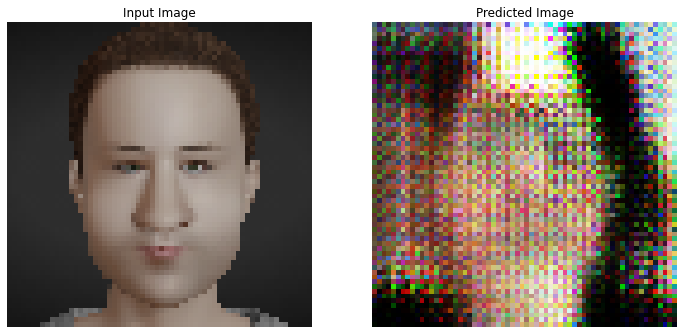

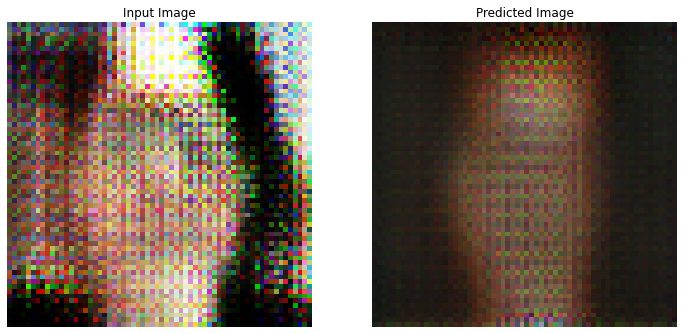

Inner Epoch Loop: 100%|██████████| 8/8 [00:00<00:00,  9.32it/s]


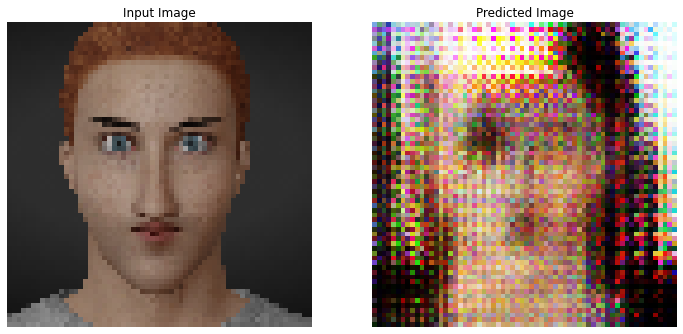

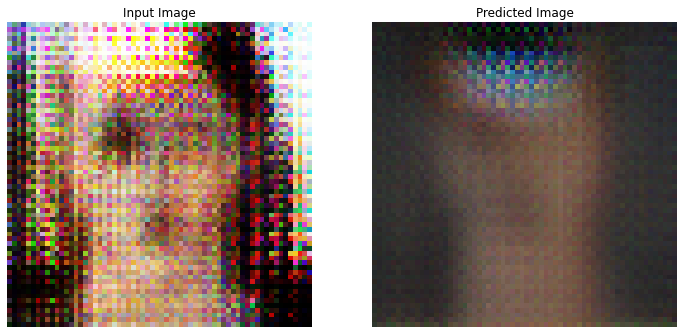

Inner Epoch Loop: 100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


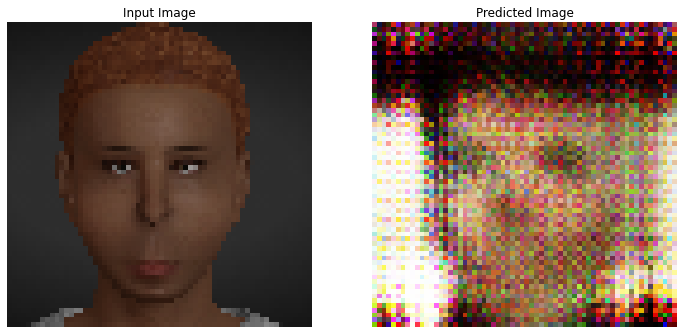

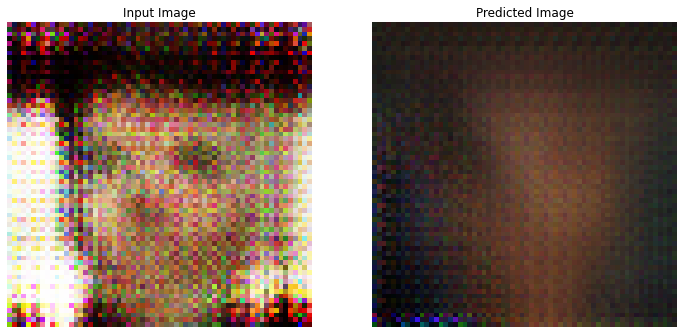

Inner Epoch Loop: 100%|██████████| 8/8 [00:00<00:00,  9.02it/s]


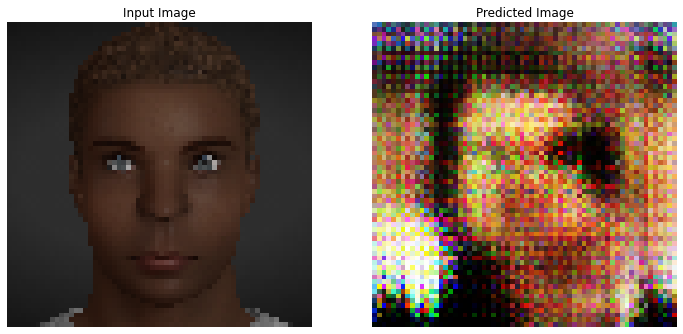

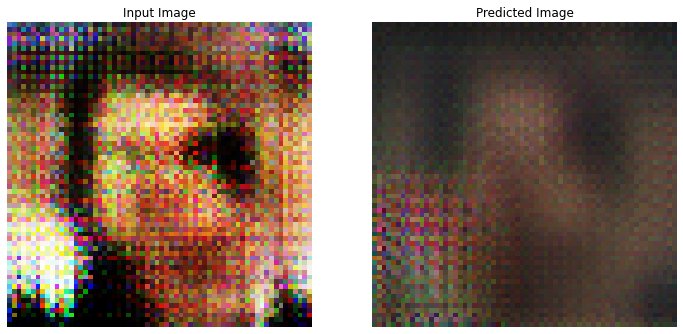

Inner Epoch Loop: 100%|██████████| 8/8 [00:00<00:00,  9.51it/s]


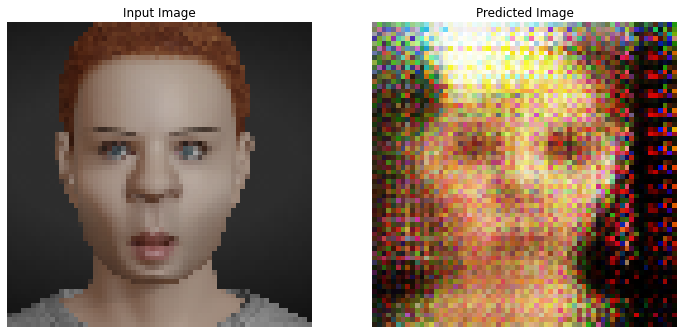

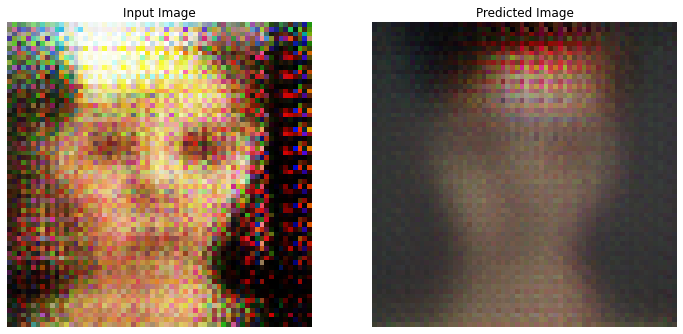

Epoch Loop:  32%|███▏      | 16/50 [00:59<02:06,  3.73s/it]


StopIteration: 

In [13]:
# epoch counter
ep_cnt = tf.Variable(initial_value=0, trainable=False, dtype=tf.int64)

# checkpoint
checkpoint = tl.Checkpoint(dict(G_A2B=G_A2B,
                                G_B2A=G_B2A,
                                D_B=D_B,
                                G_optimizer=G_optimizer,
                                D_optimizer=D_optimizer,
                                G_losses=G_losses,
                                D_losses=D_losses,
                                ep_cnt=ep_cnt),
                           py.join(output_dir, 'checkpoints_ForwardCycleGAN_BCE'),
                           max_to_keep=5)
try:  # restore checkpoint including the epoch counter
    checkpoint.restore().assert_existing_objects_matched()
except Exception as e:
    print(e)

# summary
train_summary_writer = tf.summary.create_file_writer(py.join(output_dir, 'summaries_ForwardCycleGAN_BCE', 'train'))

# sample
test_iter = iter(A_B_dataset_test)
train_iter = iter(A_B_dataset)
sample_dir = py.join(output_dir, 'samples_training_ForwardCycleGAN_BCE')
py.mkdir(sample_dir)

print(ep_cnt)
# main loop
with train_summary_writer.as_default():
    for ep in tqdm.trange(epochs, desc='Epoch Loop'):
        if ep < ep_cnt:
            continue

        # update epoch counter
        ep_cnt.assign_add(1)

        # train for an epoch
        for A, B in tqdm.tqdm(A_B_dataset, desc='Inner Epoch Loop', total=len_dataset):
            G_loss_dict, D_loss_dict, G_loss, D_loss = train_step(A, B)
            G_losses.append(G_loss)
            D_losses.append(D_loss)

            # # summary
            tl.summary(G_loss_dict, step=G_optimizer.iterations, name='G_losses')
            tl.summary(D_loss_dict, step=G_optimizer.iterations, name='D_losses')
            tl.summary({'learning rate': G_lr_scheduler.current_learning_rate}, step=G_optimizer.iterations, name='learning rate')

            # sample
            if G_optimizer.iterations.numpy() % 100 == 0:
                A, B = next(test_iter)
                A2B, A2B2A = sample(A, B)
                img = im.immerge(np.concatenate([A, A2B, A2B2A], axis=0), n_rows=1)
                im.imwrite(img, py.join(sample_dir, 'iter-%09d.jpg' % G_optimizer.iterations.numpy()))
    
        A, B = next(train_iter)
        generate_images(G_A2B, A)
        generate_images(G_B2A, G_A2B(A))
        # save checkpoint
        checkpoint.save(ep)

In [ ]:
#Plot loss values
tl.Checkpoint(dict(G_losses=G_losses, D_losses=D_losses), py.join(output_dir, 'checkpoints_CycleGAN_LS_loss')).restore()

fig = plt.figure(figsize=(16,9))
plt.plot(G_losses, label="Total Generator Loss", lw=2)
plt.plot(D_losses, label="Total Discriminator Loss", lw=2)
plt.grid(True)
plt.xlabel("batch", fontsize=20)
plt.ylabel("Loss",  fontsize=20)
plt.legend(fontsize=20, loc='best')
plt.show()

In [ ]:
tl.Checkpoint(dict(G_A2B=G_A2B, G_B2A=G_B2A), py.join(output_dir, 'checkpoints_ForwardCycleGAN_BCE')).restore()

@tf.function
def sample_A2B(A):
    A2B = G_A2B(A, training=False)
    A2B2A = G_B2A(A2B, training=False)
    return A2B, A2B2A

# run
save_dir = py.join(output_dir, 'samples_testing_ForwardCycleGAN_BCE', 'A2B')
py.mkdir(save_dir)
i = 0
for A in test_comic:
    A2B, A2B2A = sample_A2B(A)
    for A_i, A2B_i, A2B2A_i in zip(A, A2B, A2B2A):
        img = np.concatenate([A_i.numpy(), A2B_i.numpy(), A2B2A_i.numpy()], axis=1)
        im.imwrite(img, py.join(save_dir, 'iter-%09d.jpg' % i))
        i += 1

In [ ]:
# Visual Evaluation
test_length = batch_size * 20
sample_test_comic = tf.data.Dataset.from_tensor_slices(dataset_comic[0:test_length])
sample_test_comic = sample_test_comic.map(test_parse_func, num_parallel_calls=AUTOTUNE).cache().batch(batch_size)

iterator = iter(sample_test_comic)
for i in range(20):
    generate_images(G_A2B, next(iterator))

In [ ]:
# FID evaluation
def convertImagesToActivationArray(dataset, toGenerate):
    activation_list = []
    for images in dataset:
        if toGenerate:
            images = G_A2B(images)
        for image in images:
            activation = tf.reshape(imageToFeatureVector(image), (2048), name=None)
            activation_list.append(activation)
    return np.array(activation_list)

def getFid(activations1, activations2):
    mu1, sigma1 = activations1.mean(axis=0), cov(activations1, rowvar=False)
    mu2, sigma2 = activations2.mean(axis=0), cov(activations2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

print("real data set to real numpy")
actications_real_numpy = convertImagesToActivationArray(test_real, False)

print("comic data set to real numpy")
actications_comic_numpy = convertImagesToActivationArray(test_comic, False)

print("generated data set to real numpy")
actications_generated_numpy = convertImagesToActivationArray(test_comic, True)

print("FID from real and comic data set : ")
print(getFid(actications_real_numpy, actications_comic_numpy))

print("FID from real and generated data set : ")
print(getFid(actications_real_numpy, actications_generated_numpy))

print("FID from comic and generated data set : ")
print(getFid(actications_comic_numpy, actications_generated_numpy))